In [2]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools

In [3]:
include("../utill.jl")

plot_projections (generic function with 1 method)

In [4]:
function cov_matr(smpl_tmp)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl ./ std(smp_fl, FrequencyWeights(w), 2)
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

cov_matr (generic function with 1 method)

In [5]:
@load "../../data/sampling_results/Benchmark-9/mcmc-summary-data.jld" summary_data

1-element Array{Symbol,1}:
 :summary_data

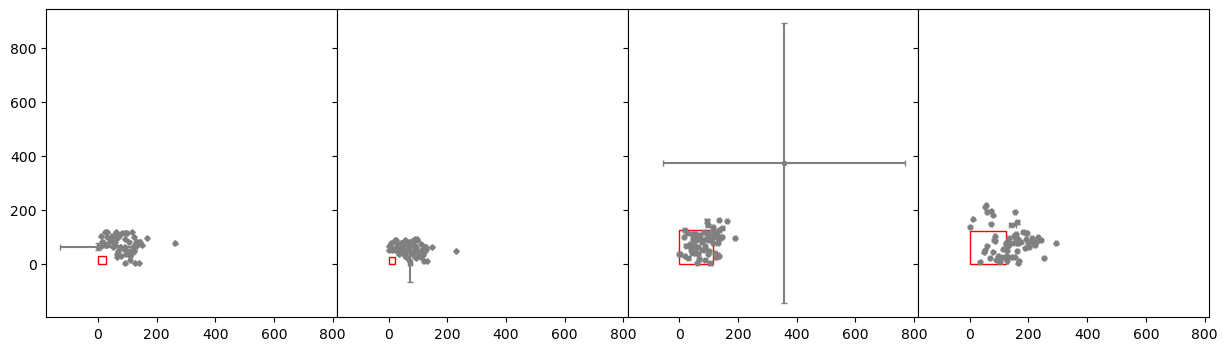

PyObject <matplotlib.patches.Rectangle object at 0x7fcb704598b0>

In [6]:
fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[1] for i in summary_data.μx_align]
y_tmp = [i[1] for i in summary_data.μy_align]
x_std = [i[1] for i in summary_data.σx_align]
y_std = [i[1] for i in summary_data.σy_align]
ax[1].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[2] for i in summary_data.μx_align]
y_tmp = [i[2] for i in summary_data.μy_align]
x_std = [i[2] for i in summary_data.σx_align]
y_std = [i[2] for i in summary_data.σy_align]
ax[2].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[3] for i in summary_data.μx_align]
y_tmp = [i[3] for i in summary_data.μy_align]
x_std = [i[3] for i in summary_data.σx_align]
y_std = [i[3] for i in summary_data.σy_align]
ax[3].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[4] for i in summary_data.μx_align]
y_tmp = [i[4] for i in summary_data.μy_align]
x_std = [i[4] for i in summary_data.σx_align]
y_std = [i[4] for i in summary_data.σy_align]
ax[4].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")

rect = matplotlib.patches.Rectangle([0,0,], 27.1,30.5,linewidth=1,edgecolor="r",facecolor="none")
ax[1].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  21.6, 23.4,linewidth=1,edgecolor="r",facecolor="none")
ax[2].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  114.0, 125.0,linewidth=1,edgecolor="r",facecolor="none")
ax[3].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  121.8, 120.0,linewidth=1,edgecolor="r",facecolor="none")
ax[4].add_patch(rect)


In [ ]:
n_events = 16
n_cameras = 4

prior_ang = NamedTupleDist(
    θ = [10^-15 .. 10^-4 for i in 1:n_events],
    α = [0 .. 2*pi  for i in 1:n_events],
    x_alignm = [-300 .. 300 for i in 1:3],
    y_alignm = [-300 .. 300 for i in 1:3],
#     σ_x = [0 .. 0.8, 0 .. 0.8, 0 .. 0.8],
#     σ_y = [0 .. 0.8, 0 .. 0.8, 0 .. 0.8],
    σ = [0 .. 0.8],
);

In [ ]:
# @show summary_data.ev_index[1:16]

In [ ]:
function log_lik(; data = summary_data, nevents = n_events)
    
    nevents = n_events
    s_cam = Float64[1.478, 15.026, 23.1150]
    data_ind = 17:32
    return params -> begin   
        
        ll = 0.0
    
        for (ind, val) in enumerate(data_ind)
            
            x_expected = cos(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            y_expected = sin(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            
            x_expected += data.μx_align[val][1] .+ params.x_alignm 
            y_expected += data.μy_align[val][1] .+ params.y_alignm
            
#             ll += sum(logpdf.(Normal.(1, params.σ_x), x_expected./data.μx_align[val][2:end] ))
#             ll += sum(logpdf.(Normal.(1, params.σ_y), y_expected./data.μy_align[val][2:end] ))
            
            ll += sum(logpdf.(Normal(1, params.σ[1]), x_expected./data.μx_align[val][2:end] ))
            ll += sum(logpdf.(Normal(1, params.σ[1]), y_expected./data.μy_align[val][2:end] ))
            
        end
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

In [ ]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [ ]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [ ]:
iter = 80000
iter_warmup = 700
chains = 4;


In [ ]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)

hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor);

In [ ]:
# par_test = rand(prior_ang)
# @time log_likelihood(par_test)
#@benchmark log_likelihood(par_test)

In [ ]:
@time samples_is = bat_sample(posterior_is, iter, MCMCSampling(sampler = hmc_sampler, nchains = chains));

In [ ]:
samples = samples_is.result;

In [ ]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [ ]:
sz = size(flatview(unshaped.(samples.v)))

In [ ]:
# BAT.bat_write("../../data/sampling_results/Benchmark-5/alignment/samples-batch-1.hdf5", unshaped.(samples))

In [ ]:
plot(flatview(unshaped.(samples.v))[3,:])

In [ ]:
covm = cov_matr(samples);

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,7), gridspec_kw=Dict("width_ratios"=>[15,1]))

max_tmp = maximum(abs.(covm))

cb = ax.imshow(covm,  origin="upper", cmap="seismic", vmin=-max_tmp, vmax=max_tmp, aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Covariance", cax=ax2)

# ax.set_yticks(0:26)
# ax.set_yticklabels(labels)

# ax.set_xticks(0:26)
# ax.set_xticklabels(labels, rotation = 90);

In [ ]:
param_mode = mode(samples)

In [ ]:
bat_marginalmode(samples).result

In [ ]:
mean(samples)[1]

In [ ]:
std(samples)[1]

In [ ]:
#  findmode_result = bat_findmode(posterior, MaxDensityLBFGS(init = InitFromTarget()), )

findmode_result = bat_findmode(
    posterior, 
    MaxDensityLBFGS(init = ExplicitInit([param_mode],)), 
)

fit_par_values = findmode_result.result[1]

In [ ]:
# @save "../../data/sampling_results/Benchmark-5/alignment/hc-data.jld2" data fit_par_values

In [ ]:
dims = 1:n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = n_events+1:2*n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = collect(sz[1]-11:sz[1]-6)
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.95, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = collect(sz[1]-5:sz[1])
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
function predict_position(x0, y0, θ, α; s = Float64[1.478, 15.026, 23.1150])
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

In [ ]:

event_ind = 10

fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[2] for i in summary_data.μx_align]
y_tmp = [i[2] for i in summary_data.μy_align]
x_std = [i[2] for i in summary_data.σx_align]
y_std = [i[2] for i in summary_data.σy_align]
ax[2].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[2].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[3] for i in summary_data.μx_align]
y_tmp = [i[3] for i in summary_data.μy_align]
x_std = [i[3] for i in summary_data.σx_align]
y_std = [i[3] for i in summary_data.σy_align]
ax[3].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[3].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[4] for i in summary_data.μx_align]
y_tmp = [i[4] for i in summary_data.μy_align]
x_std = [i[4] for i in summary_data.σx_align]
y_std = [i[4] for i in summary_data.σy_align]
ax[4].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[4].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[1] for i in summary_data.μx_align]
y_tmp = [i[1] for i in summary_data.μy_align]
x_std = [i[1] for i in summary_data.σx_align]
y_std = [i[1] for i in summary_data.σy_align]
ax[1].errorbar(x_tmp, y_tmp, xerr = x_std, yerr=y_std, capsize=2,  fmt = ".", color="gray")
ax[1].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

rect = matplotlib.patches.Rectangle([0,0,], 27.1,30.5,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[1].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  21.6, 23.4,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[2].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  114.0, 125.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[3].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  121.8, 120.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[4].add_patch(rect)

v1 = Float64[]
v2 = Float64[]
v3 = Float64[]
v4 = Float64[]
v5 = Float64[]
v6 = Float64[]
 
for i in samples.v
    pred_x, pred_y = predict_position(x_tmp[event_ind], y_tmp[event_ind], i.θ[event_ind], i.α[event_ind])
    pred_x += i.x_alignm
    pred_y += i.y_alignm
    
    push!(v1, pred_x[1])
    push!(v2, pred_y[1])
    
    push!(v3, pred_x[2])
    push!(v4, pred_y[2])
    
    push!(v5, pred_x[3])
    push!(v6, pred_y[3])
end

hist_tmp_1 = fit(Histogram, (v1, v2), FrequencyWeights(samples.weight), nbins=50)
hist_tmp_2 = fit(Histogram, (v3, v4), FrequencyWeights(samples.weight), nbins=50)
hist_tmp_3 = fit(Histogram, (v5, v6), FrequencyWeights(samples.weight), nbins=50)

ax[2].contour(midpoints(hist_tmp_1.edges[1]), midpoints(hist_tmp_1.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_1.weights)', 
    colors="darkred", alpha=1, antialiased=true) 

ax[3].contour(midpoints(hist_tmp_2.edges[1]), midpoints(hist_tmp_2.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_2.weights)', 
    colors="darkred", alpha=1, antialiased=true)

ax[4].contour(midpoints(hist_tmp_3.edges[1]), midpoints(hist_tmp_3.edges[2]), broadcast(x-> x>1 ? x : NaN, hist_tmp_3.weights)', 
    colors="darkred", alpha=1, antialiased=true)

ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 250)

In [ ]:
dt = Float64[i[event_ind] for i in samples.v.α]
hist_v = fit(Histogram, dt, FrequencyWeights(round.(Int64, samples.weight)), nbins=100)
hist_v = normalize(hist_v, mode=:pdf)

fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

ax.plot(midpoints(hist_v.edges[1]), 
        hist_v.weights, 
        lw=1.2,  "o-", 
        color= "red", 
        alpha=0.8, 
        marker="None") 


ax.grid(alpha=0.2)
# ax.set_yticklabels([])
ax.set_title("Azimuthal Angle Probability φ")